# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
!pip install seaborn
!pip install nltk
!pip install wordcloud

    100% |################################| 215kB 5.8MB/s ta 0:00:01
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 1.4MB 10.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |############

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
conn = sqlite3.connect('final.sqlite')

In [4]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [5]:
data.shape

(364171, 12)

In [6]:
# Sampling the data :
sample_data = data.sample(n=20000)
sample_data['Score'].value_counts()

positive    16948
negative     3052
Name: Score, dtype: int64

## Getting important words using TFIDF :

In [7]:
# Generating TFIDF features.
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(sample_data['CleanedText'].values)
tf_train.shape

(20000, 17957)

In [8]:
# Getting words :
word = tfidf.get_feature_names()
word[200:210]

['advertis',
 'advertisibg',
 'adverts',
 'advic',
 'advid',
 'advil',
 'advis',
 'advisor',
 'advoc',
 'advocado']

In [9]:
# Now we have to get TOP N Features :->
# Code From -> https://buhrmann.github.io/tfidf-analysis.html
def get_top_n_features(row, features, top_n): #Function takes in a row.
    # returns a dataframe with top n features :
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [10]:
tfidf_mean = np.mean(tf_train, axis = 0)
tfidf_mean = np.array(tfidf_mean)[0].tolist()

In [12]:
top_feat = get_top_n_features(tfidf_mean, word, 2000)
top_feat.shape

(2000, 2)

In [13]:
# Displaying the top 5 features out of top 2000 features obtained.
top_feat.head()

,feature,tfidf
0,tast,0.029218
1,like,0.027982
2,great,0.026463
3,love,0.026200
4,good,0.025833


## Getting the Co Occurance Matrix :

In [14]:
# Accepts a dataframe with all columns and number of features to select...
# returns a Cooccurance Matrix of size n = number of features passed as an argument.
def getCooccuranceMatrix(sample_data, numfeat):
    # Get the Top Features !!!
    print("Getting top features")
    tfidf = TfidfVectorizer(max_features = numfeat)
    tf_train = tfidf.fit_transform(sample_data['CleanedText'].values)
    # Store feature names
    words = tfidf.get_feature_names()
    # Displaying top 5 features
    tfidf_mean = np.mean(tf_train, axis = 0)
    tfidf_mean = np.array(tfidf_mean)[0].tolist()
    
    top_feat = get_top_n_features(tfidf_mean, words, numfeat)
    print("Done.")
    print("Printing some features ")
    print(top_feat.head())
    print("\n********************************")
    
    print("Generating cooccurance matrix \n")
    # Generate n X n matrix and fill initially with 0.
    arr = np.array([[0 for x in range(numfeat)] for x in range(numfeat)])
    df = pd.DataFrame(arr, index=words, columns=words)
    k = 0
    total = sample_data.shape[0]
    div = total / 10
    
    # Start reading each sentence..
    for sent in sample_data['CleanedText']:
        sent = sent.decode('utf-8')
        #Split the sentence into words.
        words = sent.split(" ")
        for i in range(len(words)):
            # Check in context with wordi , check 5 neighbours , if present in matrix add to the sum else ignore.
            for j in range(1,6):
                if(i + j < len(words) and words[i] != words[j]):
                    try:
                        df.loc[words[i], words[j]] += 1 # If word i occurs in the proximity of word j add +1 to matrix.
                        df.loc[words[j], words[i]] += 1 # Same as above for word j
                    except:
                        pass
        # This is for checking the progess
        if(k % div == 0 and k != 0):
            percent = float(k/total) * 100.0
            print("Percentage Completed:{}%".format(percent))
                
        k = k + 1
    print("Done!!")         
    return (df, top_feat['feature'])

In [15]:
df, top_feat_names = getCooccuranceMatrix(sample_data, 2000)

Getting top features
Done.
Printing some features 
  feature     tfidf
0    tast  0.033049
1    like  0.031832
2   great  0.029909
3    love  0.029764
4    good  0.029234

********************************
Generating cooccurance matrix 

Percentage Completed:10.0%
Percentage Completed:20.0%
Percentage Completed:30.0%
Percentage Completed:40.0%
Percentage Completed:50.0%
Percentage Completed:60.0%
Percentage Completed:70.0%
Percentage Completed:80.0%
Percentage Completed:90.0%
Done!!


In [16]:
df.shape

(2000, 2000)

In [17]:
# For 5000 top words:
df_2, top_feat_names_2 = getCooccuranceMatrix(sample_data, 5000)

Getting top features
Done.
Printing some features 
  feature     tfidf
0    tast  0.030553
1    like  0.029278
2   great  0.027694
3    love  0.027473
4    good  0.027058

********************************
Generating cooccurance matrix 

Percentage Completed:10.0%
Percentage Completed:20.0%
Percentage Completed:30.0%
Percentage Completed:40.0%
Percentage Completed:50.0%
Percentage Completed:60.0%
Percentage Completed:70.0%
Percentage Completed:80.0%
Percentage Completed:90.0%
Done!!


## Truncated SVD :

In [19]:
# Accepts a cooccurance matrix and a list of k, to choose from
# Returns U, Sigma, VT
# Prints variance of individual components and a plot showing how many components need for most variance explained.
def SVDTruncated(matrix, k):
    # Variance will store the value of explained variance for each value of k
    variance = []
    maxexp = -1
    svdret = 0
    for comp in k:
        svd = TruncatedSVD(n_components=comp)
        svd.fit(matrix)
        expsum = svd.explained_variance_ratio_.sum() # Calculate the explained variance ratio sum.
        variance.append(expsum)
        if expsum > maxexp: # Store the svd which explained maximum variance.
            svdret = svd
            maxexp = expsum

    # Plotting for best value of K
    plt.plot(k, variance)
    plt.title("Variance Explained vs. Number of Components")
    plt.xlabel("K")
    plt.ylabel("Total Variance Explained in %")
    plt.show()
    U = svdret.transform(matrix)
    VT = svdret.components_
    
    arr = np.array([[0 for x in range(svdret.singular_values_.shape[0])] for x in range(svdret.singular_values_.shape[0])])
    for i in range(svdret.singular_values_.shape[0]):
        arr[i, i] = svdret.singular_values_[i]
        
    Sigma = arr
    return (U, Sigma, VT)

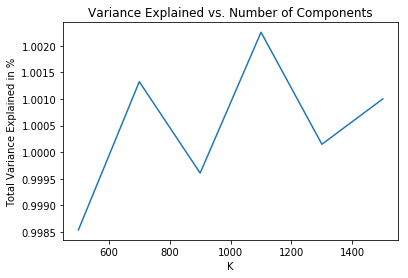

In [20]:
U, Sigma, VT = SVDTruncated(df, [500, 700, 900, 1100, 1300, 1500])

In [21]:
print(U.shape, " ", Sigma.shape, " ", VT.shape)

(2000, 1100)   (1100, 1100)   (1100, 2000)


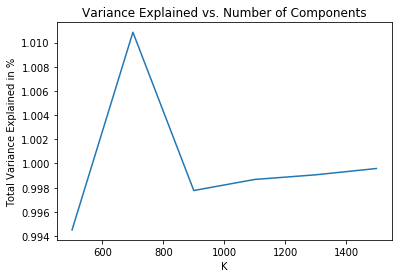

In [22]:
U_2, Sigma_2, VT_2 = SVDTruncated(df_2, [500, 700, 900, 1100, 1300, 1500])

## Clustering :
> Here we will perform clustering and group them. After grouping we will see the similarity of words in the clusters

In [24]:
kmeans = KMeans(n_clusters=10, verbose=1).fit(U)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 44552038.5027
start iteration
done sorting
end inner loop
Iteration 1, inertia 44087942.9491
start iteration
done sorting
end inner loop
Iteration 2, inertia 44017726.4233
start iteration
done sorting
end inner loop
Iteration 3, inertia 43983739.8406
start iteration
done sorting
end inner loop
Iteration 4, inertia 43968285.9403
start iteration
done sorting
end inner loop
Iteration 5, inertia 43958127.1928
start iteration
done sorting
end inner loop
Iteration 6, inertia 43953285.0233
start iteration
done sorting
end inner loop
Iteration 7, inertia 43933369.4578
start iteration
done sorting
end inner loop
Iteration 8, inertia 43933369.4578
center shift 0.000000e+00 within tolerance 1.018866e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 46367529.5838
start iteration
done sorting
end inner loop
Iteration 1, inertia 45756959.9338
start iteration
done sortin

Iteration 7, inertia 45283281.3304
start iteration
done sorting
end inner loop
Iteration 8, inertia 45277960.3851
start iteration
done sorting
end inner loop
Iteration 9, inertia 45277960.3851
center shift 0.000000e+00 within tolerance 1.018866e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 52562469.4366
start iteration
done sorting
end inner loop
Iteration 1, inertia 51934939.6238
start iteration
done sorting
end inner loop
Iteration 2, inertia 51390574.4274
start iteration
done sorting
end inner loop
Iteration 3, inertia 50955875.6508
start iteration
done sorting
end inner loop
Iteration 4, inertia 50867276.8363
start iteration
done sorting
end inner loop
Iteration 5, inertia 50824125.5853
start iteration
done sorting
end inner loop
Iteration 6, inertia 50747622.7867
start iteration
done sorting
end inner loop
Iteration 7, inertia 50691383.3685
start iteration
done sorting
end inner loop
Iteration 8, inertia 50685345.3308
start iteration


In [25]:
# Now the model has been trained, we now create a a dataframe and assign each point in U with its cluster label.
# We will also add the corresponding word to it.
wcd = pd.DataFrame(U)
wcd['Groups'] = kmeans.labels_
wcd['words'] = top_feat_names
wcd.head()

,0,1,2,3,4,5,6,7,8,9,...,1092,1093,1094,1095,1096,1097,1098,1099,Groups,words
0,276.277503,28.772212,-19.010278,0.911964,-16.636239,-3.590581,47.966500,-4.766893,-1.514898,0.098550,...,0.292968,0.325709,-0.922947,0.236313,0.682874,0.327395,-0.618030,0.135177,1,tast
1,326.158012,40.947481,11.196818,20.846168,26.323978,-28.331668,-20.011344,33.426686,33.259615,-8.324171,...,-0.260202,-0.898795,0.088213,0.349120,-0.773373,0.495542,-0.410334,-0.002009,7,like
2,16.761696,4.928321,0.466225,1.259142,-1.584786,1.901326,4.506078,-2.412677,-0.839879,6.229125,...,0.265516,0.736171,-0.506737,-0.110005,-0.449636,0.387192,0.508492,0.200725,3,great
3,21.999547,-1.853769,-3.059929,-1.912957,3.515482,-0.711183,1.760539,-2.449822,0.207817,2.944883,...,-0.220994,0.341317,-0.148782,0.896784,-0.145467,-0.088816,0.004231,-0.413003,3,love
4,17.392907,7.741107,-1.643192,-2.234742,4.124322,-6.695684,1.506998,-1.769935,-1.161744,-0.394647,...,-0.519517,-0.689160,0.029303,-0.394544,-0.533341,0.019526,0.245528,0.046146,3,good


In [26]:
# Grouping based on the cluster labels.
wcdgroup = wcd.groupby(['Groups'])

In [27]:
wcdgroup.groups

{0: Int64Index([  44,   47,   49,  109,  115,  149,  185,  187,  192,  270,  312,
              426,  445,  460,  489,  574,  585,  587,  588,  632,  657,  688,
              692,  736,  752,  771,  839,  855,  957, 1008, 1013, 1019, 1024,
             1035, 1047, 1107, 1120, 1151, 1157, 1186, 1189, 1204, 1219, 1220,
             1323, 1349, 1412, 1560, 1585, 1678, 1694, 1708, 1729, 1781, 1782,
             1840, 1860, 1913, 1922, 1925, 1936, 1965],
            dtype='int64'),
 1: Int64Index([   0,   13,   14,   36,   38,   41,   43,   45,   46,   60,
             ...
             1963, 1967, 1971, 1973, 1977, 1986, 1988, 1991, 1993, 1997],
            dtype='int64', length=382),
 2: Int64Index([ 147,  228,  513,  516,  532,  551,  651,  679,  730,  918, 1041,
             1130, 1202, 1385, 1798, 1972, 1983],
            dtype='int64'),
 3: Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   15,   16,
             ...
             1985, 1987, 1989, 1990, 1992, 1994, 1995, 199

In [28]:
# Using the groups formed we will store all words which have been grouped into one cluster for plotting lateron.
sent = list()
for i in range(0,10):
    string = " "
    for x in wcdgroup.groups[i]:
        # Get the words which belong to cluster i and store in sentence i.
        string += wcd.loc[x, 'words']
        string += " "
    sent.append(string)
    
len(sent)

10

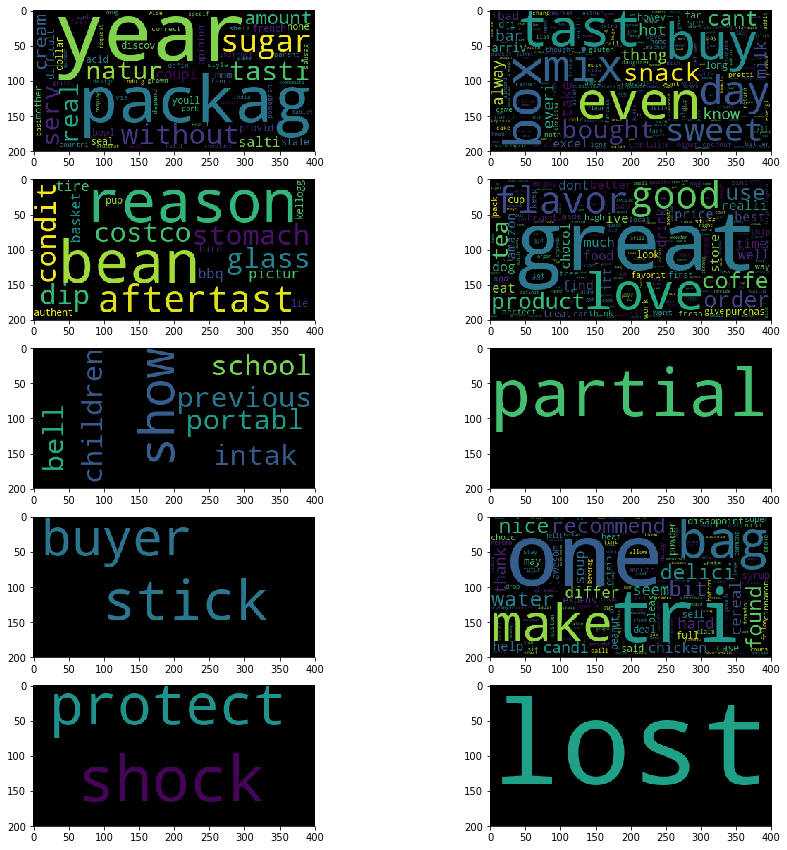

In [55]:
# Displaying the wordcloud of words in each cluster.
fig, ax = plt.subplots(nrows = 5, ncols= 2,figsize=(15,15))
j = 0
k = 0
for i in range(10):
    # Generate WordCloud
    wordcloud = WordCloud().generate(sent[i])
    ax[k][j].imshow(wordcloud)
    j = (j+1)%2
    if j == 0 and i > 0:
        k = k + 1
plt.show()

> We can see that some clusters have only one or two words and some have many more words. Some words have been grouped well where as some are not. Like for cluster 4 tea , coffee and flavour are all here in same cluster but for cluster 5 words grouped are not related.

<b> For 5000 words now </b>

In [56]:
kmeans = KMeans(n_clusters=10, verbose=1).fit(U_2)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 43040068.706
start iteration
done sorting
end inner loop
Iteration 1, inertia 42503946.6356
start iteration
done sorting
end inner loop
Iteration 2, inertia 42449312.3424
start iteration
done sorting
end inner loop
Iteration 3, inertia 42445477.83
start iteration
done sorting
end inner loop
Iteration 4, inertia 42442587.7601
start iteration
done sorting
end inner loop
Iteration 5, inertia 42440969.1102
start iteration
done sorting
end inner loop
Iteration 6, inertia 42440788.2076
start iteration
done sorting
end inner loop
Iteration 7, inertia 42440525.3198
start iteration
done sorting
end inner loop
Iteration 8, inertia 42439063.2845
start iteration
done sorting
end inner loop
Iteration 9, inertia 42436968.6764
start iteration
done sorting
end inner loop
Iteration 10, inertia 42432663.6134
start iteration
done sorting
end inner loop
Iteration 11, inertia 42427805.4279
start iteration
done sorting


Iteration 11, inertia 43725841.7145
start iteration
done sorting
end inner loop
Iteration 12, inertia 43688441.5735
start iteration
done sorting
end inner loop
Iteration 13, inertia 43673884.0217
start iteration
done sorting
end inner loop
Iteration 14, inertia 43667976.6024
start iteration
done sorting
end inner loop
Iteration 15, inertia 43662995.1562
start iteration
done sorting
end inner loop
Iteration 16, inertia 43662995.1562
center shift 0.000000e+00 within tolerance 7.023592e-03
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 45126768.503
start iteration
done sorting
end inner loop
Iteration 1, inertia 44148140.2917
start iteration
done sorting
end inner loop
Iteration 2, inertia 43900430.6895
start iteration
done sorting
end inner loop
Iteration 3, inertia 43783499.2644
start iteration
done sorting
end inner loop
Iteration 4, inertia 43756836.1863
start iteration
done sorting
end inner loop
Iteration 5, inertia 43740282.0119
start itera

In [57]:
# Now the model has been trained, we now create a a dataframe and assign each point in U with its cluster label.
# We will also add the corresponding word to it.
wcd = pd.DataFrame(U_2)
wcd['Groups'] = kmeans.labels_
wcd['words'] = top_feat_names_2
wcd.head()

,0,1,2,3,4,5,6,7,8,9,...,692,693,694,695,696,697,698,699,Groups,words
0,13.200707,0.655896,-0.942406,1.810645,3.145615,2.188384,0.086406,0.364747,-0.091038,-1.981516,...,-0.484091,-0.196682,-0.222903,0.118484,0.589486,-0.791612,0.808722,-0.025765,0,tast
1,276.414901,27.792653,-19.356142,0.245141,-10.700170,-3.619524,11.143469,46.046488,0.966878,6.585477,...,0.045403,-0.819799,-2.525481,0.531014,-1.334692,-0.079088,0.948449,0.381046,5,like
2,7.395828,0.742756,0.599187,0.473304,-0.160777,0.055557,1.489186,1.343225,0.471823,1.162719,...,-0.038013,-0.530320,-0.011486,-1.023540,0.288045,0.095972,0.190558,-0.370608,0,great
3,326.322082,40.667587,9.824803,20.767965,26.460111,-23.622408,25.492547,-36.939159,29.032770,-8.966294,...,-1.923676,-1.479089,0.684379,2.122615,1.382011,4.039937,-0.009024,-1.132043,5,love
4,16.781390,4.920586,0.345379,1.311793,-1.714371,1.688352,-0.829494,6.882605,-0.314411,0.399231,...,-0.764243,-0.357449,-0.680246,0.124517,-0.139917,0.289405,-0.122692,-0.580157,0,good


In [58]:
# Grouping based on the cluster labels.
wcdgroup = wcd.groupby(['Groups'])
wcdgroup.groups

{0: Int64Index([   0,    2,    4,    5,    6,    7,    8,    9,   10,   11,
             ...
             4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],
            dtype='int64', length=4221),
 1: Int64Index([ 117,  127,  279,  454,  463,  476,  658,  766, 1063, 1215, 1293,
             1486, 1593, 1640, 1652, 1736, 2553, 2575, 2651, 2803, 2855, 3059,
             3387, 3463, 3780, 4219, 4338, 4805, 4822, 4848],
            dtype='int64'),
 2: Int64Index([2527], dtype='int64'),
 3: Int64Index([1666, 1899, 1946, 2588, 3039, 3410, 4591, 4706], dtype='int64'),
 4: Int64Index([  26,   28,   37,   38,   44,   53,   65,   72,  105,  108,
             ...
             4931, 4932, 4934, 4936, 4953, 4955, 4960, 4965, 4969, 4980],
            dtype='int64', length=513),
 5: Int64Index([   1,    3,   32,   33,   71,  109,  126,  138,  151,  164,
             ...
             4448, 4479, 4483, 4637, 4710, 4723, 4727, 4841, 4876, 4904],
            dtype='int64', length=152),
 6: Int

In [59]:
# Using the groups formed we will store all words which have been grouped into one cluster for plotting lateron.
sent = list()
for i in range(0,10):
    string = " "
    for x in wcdgroup.groups[i]:
        # Add the words which belong to cluster i, into sentence i
        string += wcd.loc[x, 'words']
        string += " "
    sent.append(string)
    
len(sent)

10

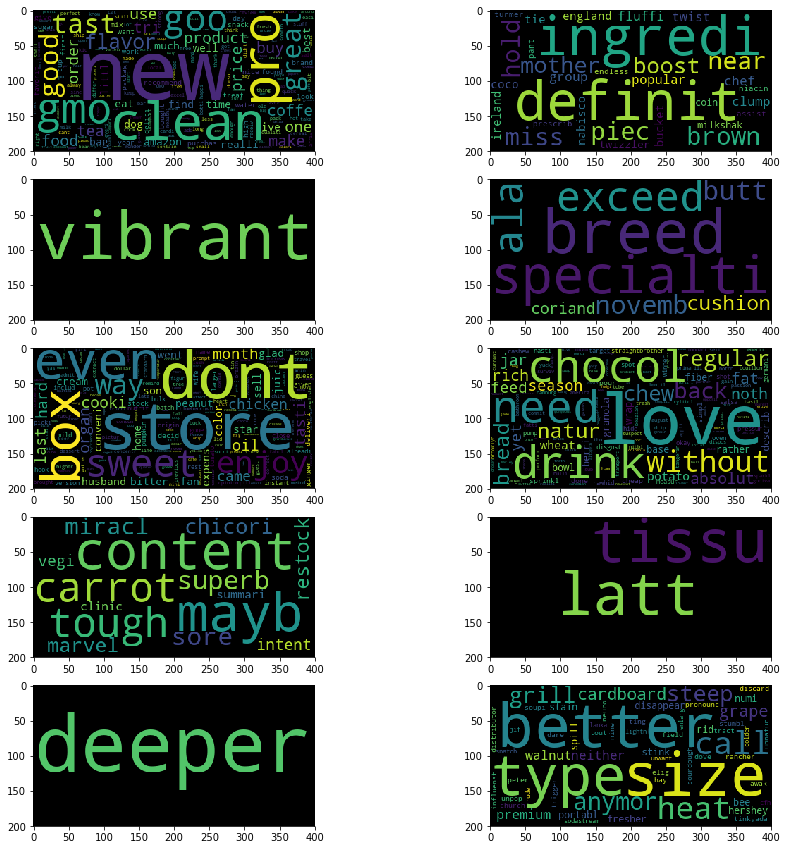

In [60]:
# Displaying the wordcloud of words in each cluster.
fig, ax = plt.subplots(nrows = 5, ncols= 2,figsize=(15,15))
j = 0
k = 0
for i in range(10):
    # Generate WordCloud
    wordcloud = WordCloud().generate(sent[i])
    ax[k][j].imshow(wordcloud)
    j = (j+1)%2
    if j == 0 and i > 0:
        k = k + 1
plt.show()

> Here also we see that same thing, some clusters contain only 1 word and some are grouped well and some arent.